# Applying Unrestricted Density-Matrix Embedding Theory to battery chemistry

## Introduction

<!--- Approach with PD --->
Density-Matrix Embedding Theory (DMET) is part of a toolset we call problem decomposition methods, which breaks down a molecular problem into a collection of smaller subproblems requiring a lower amount of computational resources (classical or quantum). In another [notebook](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/problem_decomposition/dmet.ipynb), we introduced the DMET algorithm, its relevance, and implemented features in [Tangelo](https://github.com/goodchemistryco/Tangelo).

Some conclusions can be drawn from this educational resource:
- There is a tradeoff between the DMET fragmentation (number of atoms per fragment) and the DMET energy accuracy;
- Each fragment can be treated independently;
- The 1- and  2-body Reduced Density Matrices (RDMs) are the information needed for each fragment to recontruct the full system wavefunction.

<!--- Restricted DMET --->
When not explicitly mentioned, DMET's underlying mean-field calculation for each fragment generally refers to a restricted Hartree-Fock calculation, meaning the spin orbitals are treated as pairs. As stated in [Szabo & Ostlund](https://books.google.ca/books/about/Modern_Quantum_Chemistry.html?id=6mV9gYzEkgIC&redir_esc=y), the lowest mean-field energy of a molecule with unpaired electrons is retrieved from an unrestricted calculation. According to the from the Unrestricted Hartree–Fock [wiki page](https://en.wikipedia.org/wiki/Unrestricted_Hartree%E2%80%93Fock):

> "(...) the unrestricted Hartree–Fock method is used frequently, and in preference to the restricted open-shell Hartree–Fock (ROHF) method, because UHF is simpler to code, easier to develop post-Hartree–Fock methods with, and returns unique functions unlike ROHF where different Fock operators can give the same final wave function." 

More information on those concepts can be found in the [quantum chemistry modelling notebook](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/chemistry/qchem_modelling_basics.ipynb).

<!--- Free radicals and battery chemistry --->
Expanding DMET calculations beyond the restricted formalism opens up the application of this problem decomposition scheme to free radicals (at least one unpaired valence electron). Those molecules, although rarely present in a stable form at standard temperature and pressure, can be found as intermediate species in chemical reactions. As a consequence, they are important for modelling kinetics in complex chemical systems. One example of those complex systems is battery chemistry, where understanding energy transfer between chemicals is essential to further develop this technology. On this point, quantum simulation for battery chemistry has attracted some attention with public announcements and scientific publications. The [Mercedes-Benz](https://doi.org/10.1103/PhysRevResearch.4.023019) (with PsiQuantum), [Ford](https://arxiv.org/abs/2208.07977) and [Volkswagen](https://doi.org/10.1103/PhysRevA.106.032428) (with Xanadu) initiatives are part of this push. While the first and third studies bring insights on the resources required to tackle quantum simulation for battery chemistry with fault-tolerant algorithms, the second study could be categorized as a NISQ-friendly approach. However, the estimated circuit depths are still way beyond existing device capabilities, as it yields circuits of $10^5 - 10^6$ moments.

<!--- UHF + DMET --->
While waiting for a hardware breakthrough towards fault-tolerant quantum computers, unrestricted DMET calculation (UHF-DMET) may help modelling more industrially-relevant molecules on Noisy Intermediate Scale Quantum (NISQ) devices. We have previously addressed this statement with restricted DMET calculations in a [Communcation Physics publication](https://doi.org/10.1038/s42005-021-00751-9), reproduced in the ["overview of an end-to-end experiment" notebook](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/hardware_experiments/overview_endtoend.ipynb). In this notebook, we focus on a use case relevant for battery chemistry development using the UHF-DMET algorithm. The quantum resource estimation and experiment are intentionally left out of this notebook as they are already covered in the references above.

But first, let's install Tangelo in our environment.

In [1]:
try:
  import tangelo
except ImportError:
  !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

## Tackling the $\text{LiO}_2$ Molecule with DMET and Classical Solvers

We tackle the ground-state preparation of the lithium superoxide ($\text{LiO}_2$) molecule, using UHF-DMET. $\text{LiO}_2$ is a chemical compound formed in an electrolytic cell from the reaction of a lithium ion with oxygen at the cathode: 

$$\text{Li}^+ + \text{e}^- + \text{O}_2 -> \text{LiO}_2$$ 

The stabilization of this compound could lead to a new type of batteries with improved energy density, as stated in this [phys.org news article](https://phys.org/news/2016-01-stable-superoxide-door-class-batteries.html). To study this compound, a wet chemistry analog of this process would be the $\text{LiO}_2$ synthesis from lithium electride dissolved in anhydrous ammonia.

Via quantum chemistry theory, we know that the $\text{LiO}_2$ molecule is described by 42 molecular orbitals (in the STO-3G basis) and 19 electrons. This problem statement involves computational challenges due to the exponential scaling of the matrix and vector sizes for classical algorithms, like the Full Configuration Interaction (FCI) method. This aspect grows into a bigger issue as we move on to more complete basis sets, and this is one of the reasons why [quantum chemistry is so complicated](https://doi.org/10.1021/jacs.2c13042). This is a textbook example where a problem decomposition like UHF-DMET could shine.

The remaining part of this notebook shows how UHF-DMET can be used in Tangelo. In the next cell, we build a $\text{LiO}_2$ molecule object with the `cc-pvdz` basis set, using a UHF mean-field calculation (by setting the `uhf` argument to `True`). 

In [2]:
from tangelo import SecondQuantizedMolecule

LiO2 = [
    ("Li", (0., 0., 1.380605)),
    ("O", (0., 0.676045, -0.258863)),
    ("O", (0., -0.676045, -0.258863))
]
mol_lio2 = SecondQuantizedMolecule(LiO2, q=0, spin=1, basis="cc-pvdz", frozen_orbitals=None, uhf=True)

By looking at the the `n_active_ab_electrons` and `active_mos` properties, we can confirm that an unrestricted self-consistent field has been generated. The alpha and beta spin orbitals are treated separately, therefore the orbitals properties are grouped in pairs, where the first (resp. last) element of the tuple refers to the alpha (resp. beta) spin orbitals.

In [3]:
n_alpha, n_beta = mol_lio2.n_active_ab_electrons
mos_alpha, mos_beta = mol_lio2.active_mos

print(f"{n_alpha} alpha electrons in {len(mos_alpha)} molecular orbitals.")
print(f"{n_beta} beta electrons in {len(mos_beta)} molecular orbitals.")

10 alpha electrons in 42 molecular orbitals.
9 beta electrons in 42 molecular orbitals.


At the time of writing, only `CCSDSolver`, where CCSD refers to coupled-cluster singles and doubles, supports an unrestricted mean field in Tangelo. Since calculating the ground state of $\text{LiO}_2$ in the cc-pVDZ basis set with FCI is challenging (and even might be not possible) for most supercomputers, we use CCSD for the reference calculations.

In [4]:
from tangelo.algorithms.classical import CCSDSolver

ccsd = CCSDSolver(mol_lio2)
e_ccsd = ccsd.simulate()
print(f"Mean-field energy: {mol_lio2.mf_energy} Ha")
print(f"Unrestricted CCSD energy: {e_ccsd} Ha")

Mean-field energy: -157.10964086805075 Ha
Unrestricted CCSD energy: -157.4899499964378 Ha


Next, we define the DMET options and perform the simulation. 
- The molecular orbitals were localized via natural atomic orbitals (NAO);
- DMET fragments are defined to contain 1 atom each;
- The CCSD solver is used for every fragment.

In [5]:
from tangelo.problem_decomposition.dmet import Localization
from tangelo.problem_decomposition import DMETProblemDecomposition

opt_dmet = {"molecule": mol_lio2,
            "fragment_atoms": [1, 1, 1],
            "fragment_solvers": "ccsd",
            "electron_localization": Localization.nao,
            "virtual_orbital_threshold": 1e-13,
            "verbose": False
            }

dmet_solver = DMETProblemDecomposition(opt_dmet)
dmet_solver.build()
e_dmet_ccsd = dmet_solver.simulate()
print(f"Unrestricted DMET-CCSD energy: {e_dmet_ccsd} Ha")
print(f"Difference vs the unrestricted CCSD: {abs(e_ccsd - e_dmet_ccsd):.4f} Ha")

Unrestricted DMET-CCSD energy: -157.47151520319153 Ha
Difference vs the unrestricted CCSD: 0.0184 Ha


UHF-DMET here retrieves most of the correlation energy (0.36 Ha). This method requires considerably less resources than approaching the full system head on. We have turned a 42 MOS + 19 electrons electronic structure calculation into 3 smaller problems of 28 MOS + 15 (or 17) electrons. Assuming an occupation mapping such as the [Jordan-Wigner transformation](https://learn.microsoft.com/en-us/azure/quantum/user-guide/libraries/chemistry/concepts/jordan-wigner), it would mean a reduction from 84 qubits to 56.

This decomposition scheme comes at the cost of introducing an error of about 0.018 Ha when comparing to the full-molecule CCSD calculation. This is caused by a virtual orbital space truncation step done during the DMET fragment construction. This feature can be turned off by setting the `virtual_orbital_threshold` to 0 (default is $1\times10^{-13}$), at the expense of a significant increase in the computational cost of the DMET calculation. On another note, when this DMET error is more or less constant across a set of calculations (this could be a reasonable statement for the same class of molecule with similar fragmentation), this is revealed to be a powerful tool for reducting computational cost.

The last calculation has been made with a given geometry for the nuclei. If one is interested in the formation of $\text{LiO}_2$, as described earlier in this notebook, the approach of a $\text{Li}$ atom towards an $\text{O}_2$ molecule should be modelled. As a consequence, geometry changes would be a necessary component of the study.

The data below displays the energies of different $\text{LiO}_2$ geometries by varying the $\text{Li}$-$\text{O}_2$ distance. Here unrestricted CCSD refers to the calculation of CCSD with an unrestricted mean-field starting point.

<AxesSubplot: xlabel='Li-O2 distance / Angstrom', ylabel='Energy / Ha'>

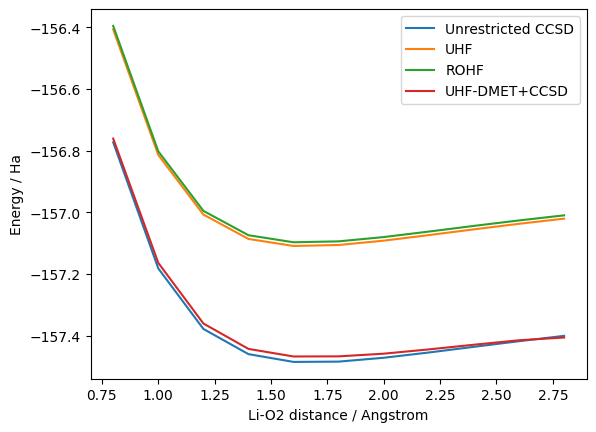

In [6]:
from io import StringIO
import pandas as pd

data = """
r, Unrestricted CCSD, UHF, ROHF, UHF-DMET+CCSD
0.8, -156.77290395144,  -156.407069154552, -156.395663251967, -156.760717950373
1.0, -157.181626088186, -156.813883767609, -156.802127699106, -157.163705479905
1.2, -157.377673286621, -157.00703363169,  -156.99505890766,  -157.360034403805
1.4, -157.459368788708, -157.086059337141, -157.07401601092,  -157.44244444947
1.6, -157.484607625707, -157.108840759645, -157.096849245497, -157.466961019203
1.8, -157.483616469896, -157.105696261544, -157.093842156837, -157.466603459799
2.0, -157.471129533643, -157.091589272408, -157.079928235107, -157.457900669265
2.2, -157.454061938212, -157.073591742696, -157.062157197992, -157.443997798073
2.4, -157.435670655538, -157.054932359744, -157.043743505371, -157.428861609471
2.6, -157.417467388055, -157.036982535102, -157.026047930188, -157.414458252749
2.8, -157.400122479842, -157.0202427614,   -157.009560505402, -157.405471025456
"""

df = pd.read_table(StringIO(data), sep=",", skipinitialspace=True)
df.plot(x="r", y=["Unrestricted CCSD", "UHF", "ROHF", "UHF-DMET+CCSD"], xlabel="Li-O2 distance / Angstrom", ylabel="Energy / Ha")

We are getting most of the correlation energy with the UHF-DMET on the full span of the configurational space. We can also see from this plot the lower energy given by an unrestricted mean-field calculation (vs restricted). We show in the next section how one can leverage this problem decomposition method to efficiently map the $\text{LiO}_2$ molecule on a (or many) quantum computer(s).

## What about the Quantum Algorithms?

Up until this section, the discussion revolved around solving the Schrödinger equation for the $\text{LiO}_2$ molecule in the `cc-pVDZ` basis set using UHF-DMET (and CCSD). As mentionned in the introduction, UHF-DMET is one of many tools that scientists have to reduce computational cost of a quantum chemistry calculation.

### Resource estimation

We shown in the previous section that a reduction of 84 qubits to 56 was possible when working in the `cc-pVDZ` basis set. However, working with this many qubits would require the accurate computation of expectation values (within 1 mHa) on deep quantum circuits. 

This is one of the reason quantum chemistry calculation on NISQ devices are often done using a minimal basis set, like `sto-3g` or `minao`. As most of the experiments serve as proofs of concept, scaling up problem size will occur accordingly to quantum hardware development. We show in the next cell a resource estimation for a DMET fragment mapping on quantum hardware, using the `sto-3g` basis set and the variational quantum eigensolver (VQE).

In [7]:
from pprint import pprint
from tangelo.algorithms.variational import BuiltInAnsatze, VQESolver

mol_lio2 = SecondQuantizedMolecule(LiO2, q=0, spin=1, basis="sto-3g", frozen_orbitals=None, uhf=True)

opt_vqe = {"molecule": mol_lio2,
           "qubit_mapping": "JW", 
           "up_then_down": True, 
           "ansatz": BuiltInAnsatze.QCC,
}
vqe_solver = VQESolver(opt_vqe)
vqe_solver.build()
print("Full VQE quantum resources:")
pprint(vqe_solver.get_resources())

opt_dmet = {"molecule": mol_lio2,
            "fragment_atoms": [1, 1, 1],
            "fragment_solvers": ["vqe", "ccsd", "ccsd"],
            "solvers_options": [{"qubit_mapping": "JW", "up_then_down": True, "ansatz": BuiltInAnsatze.QCC}, None, None],
            "electron_localization": Localization.nao,
            "virtual_orbital_threshold": 1e-13,
            "verbose": False
            }

dmet_solver = DMETProblemDecomposition(opt_dmet)
dmet_solver.build()
print("\nDMET-VQE quantum resources:")
pprint(dmet_solver.get_resources()[0])

Full VQE quantum resources:
{'circuit_2qubit_gates': 3804,
 'circuit_depth': 2965,
 'circuit_var_gates': 694,
 'circuit_width': 30,
 'qubit_hamiltonian_terms': 20548,
 'vqe_variational_parameters': 694}

DMET-VQE quantum resources:
{'circuit_2qubit_gates': 978,
 'circuit_depth': 848,
 'circuit_var_gates': 203,
 'circuit_width': 20,
 'qubit_hamiltonian_terms': 6397,
 'vqe_variational_parameters': 203}


The resource for a single DMET fragment, corresponding to the $\text{Li}$ atom, are in the order of 20 qubits and 6367 Hamiltonian terms (with a Jordan-Wigner qubit mapping). Versus the full VQE problem, this is a 33% and a 69% improvement in terms of the number of required qubits and Hamiltonian terms, respectively. This also yields a shallower circuit, with fewer variational parameters: a complete discussion on this topic depends on the ansatz choice. 

### Trade-off between energy accuracy and virtual orbital truncation in DMET fragments

We briefly touched the `virtual_orbital_threshold` parameter earlier when we discussed the DMET energy error. This discussion is even more relevant when constructing quantum circuits, as we work with minimal basis sets to restrain the number of qubits. Changing the `virtual_orbital_threshold` while dealing with smaller basis sets can have a significant impact on the DMET energy, as shown in the table below. This is due to the truncation of a few virtual orbitals having proportionally greater impact on small virtual orbital spaces than on larger ones.

| Truncation threshold | Problem size (number of qubits) | DMET error vs full CCSD (Ha) |
|---|---|---|
| $0$ | $20$ | $0.011$ |
| $10^{-2}$ | $18$ | $0.034$ |

## Closing Words

We have demonstrated the use of UHF-DMET via the modelling of the $\text{LiO}_2$ formation. DMET reduces the computational resource requirements at the cost of adding a new potential source of error induced by the fragmentation. However, if the DMET error is constant for two different calculations, the agreement with experiment can be good as energy differences are all that can be measured in laboratories.

This resource reduction is welcome when simulating chemical problems on NISQ devices. One should be aware of unanswered questions when using DMET (regardless of the flavour, with UHF or not):
- How to build accurate shallow ansatze for DMET fragments, to further reduce circuit depth compared to the full molecular problem?
- Is the measurement problem avoidable? We need to design an efficient way to extract the 2-body Reduced Density Matrices (RDMs) from each fragment solver.
- How resilient is DMET to statistical and physical noise, leading in particular to noisy 2-RDM data?

Tangelo may help you answer some of these questions. Its DMET framework facilitates the exploration of [many ansatze](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/variational_methods/vqe_custom_ansatz_hamiltonian.ipynb),  [measurement reduction](https://github.com/goodchemistryco/Tangelo-Examples/tree/main/examples/measurement_reduction) and [noisy performance](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/workflow_basics/3.noisy_simulation.ipynb) of quantum algorithms. The rest is up to you !